In [1]:
%load_ext autoreload
%autoreload 2

from config.rnn import default
from models import RNN
from functional import seq
import tensorflow as tf
from tensorpack import (TrainConfig, SyncMultiGPUTrainerParameterServer as Trainer, 
                        PredictConfig, MultiProcessDatasetPredictor as Predictor,
                        SaverRestore, logger)
from tensorpack.callbacks import (ScheduledHyperParamSetter, MaxSaver, ModelSaver,
                                  DataParallelInferenceRunner as InfRunner)
from tensorpack.predict import SimpleDatasetPredictor
from utils import DataManager
from utils.validation import (Accumulator, ApAndAucScore, calcu_ap_auc)

resnet_loc = "./data/resnet_v2_101/resnet_v2_101.ckpt"
logger.set_logger_dir('train_log')

[1015 21:04:50 @logger.py:93] WRN Log directory train_log exists! Please either backup/delete it, or use a new directory.
[1015 21:04:50 @logger.py:95] WRN If you're resuming from a previous run you can choose to keep it.
[1015 21:04:50 @logger.py:96] Select Action: k (keep) / b (backup) / d (delete) / n (new) / q (quit):
k
[1015 21:06:52 @logger.py:67] Log file 'train_log/log.log' backuped to 'train_log/log.log.1015-210652'
[1015 21:06:52 @logger.py:74] Argv: /home/fuxiaofeng/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /run/user/1012/jupyter/kernel-44620c38-312b-48e7-a419-35e92c81b4f8.json


In [2]:
config = default
config.stage = [2, 3, 4 ,5, 6]
config.annotation_number = 24
config.weight_decay = 1e-3
ignore_restore = ['learning_rate', 'global_step']
save_name = "rnn-23456-dlv-max-auc.tfmodel"

data_manager = DataManager(config)
train_data = data_manager.get_train_stream(64)
val_data = data_manager.get_validation_stream(64)
test_data = data_manager.get_test_stream(64)
model = RNN(config)

Group numbers:
    train: 4133, validation: 1228, test: 1463
Image numbers:
    train: 8266, validation: 2456, test: 2926


In [3]:
tf.reset_default_graph()
train_config = TrainConfig(model=model, dataflow=train_data, 
                           callbacks=[
                           ScheduledHyperParamSetter('learning_rate', [(0, 5e-4),(20, 1e-4)]),
                               InfRunner(val_data, [ApAndAucScore()], [0, 1]),
                               ModelSaver(),
                               MaxSaver('val-auc', save_name),
                           ], 
                           session_init=SaverRestore(model_path=resnet_loc, ignore=ignore_restore),
                           max_epoch=6, nr_tower=2)
Trainer(train_config).train()    

[1015 16:28:25 @inference_runner.py:81] InferenceRunner will eval on an InputSource of size 19
[1015 16:28:26 @input_source.py:235] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[1015 16:28:26 @input_source.py:509] Setting up StagingArea for GPU prefetching ...
[1015 16:28:26 @multigpu.py:66] Training a model of 2 towers
[1015 16:28:26 @multigpu.py:87] Building graph for training tower 0...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1015 16:28:36 @regularize.py:95] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1015 16:28:38 @multigpu.py:87] Building graph for training tower 1...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1015 16:28:42 @regularize.py:95] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1015 16:

[1015 16:29:02 @sessinit.py:119] Restoring checkpoint from ./data/resnet_v2_101/resnet_v2_101.ckpt ...
INFO:tensorflow:Restoring parameters from ./data/resnet_v2_101/resnet_v2_101.ckpt
[1015 16:29:10 @base.py:185] Graph Finalized.
[1015 16:29:10 @param.py:144] After epoch 0, learning_rate will change to 0.00050000
[1015 16:29:11 @concurrency.py:36] Starting EnqueueThread DataParallelInferenceRunner/QueueInput/input_queue ...
[1015 16:29:27 @concurrency.py:36] Starting EnqueueThread QueueInput/input_queue ...
[1015 16:29:27 @input_source.py:474] Pre-filling staging area ...
[1015 16:31:25 @base.py:231] Start Epoch 1 ...


100%|##########|64/64[07:49<00:00, 0.24it/s]

[1015 16:39:17 @base.py:241] Epoch 1 (global_step 64) finished, time:471.59 sec.



100%|##########|19/19[00:19<00:00, 0.78it/s]


[1015 16:39:38 @saver.py:90] Model saved to train_log/model-64.
[1015 16:39:38 @saver.py:159] Model with maximum 'val-auc' saved.
[1015 16:39:38 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 50
[1015 16:39:38 @monitor.py:359] QueueInput/queue_size: 0
[1015 16:39:38 @monitor.py:359] learning_rate: 0.0005
[1015 16:39:38 @monitor.py:359] loss/value: 0.20759
[1015 16:39:38 @monitor.py:359] val-auc: 0.86682
[1015 16:39:38 @monitor.py:359] val-average-precision: 0.53468
[1015 16:39:38 @monitor.py:359] val-loss: 0.56638
[1015 16:39:38 @group.py:42] Callbacks took 21.416 sec in total. DataParallelInferenceRunner: 20.016sec
[1015 16:39:38 @base.py:231] Start Epoch 2 ...


100%|##########|64/64[12:04<00:00, 0.07it/s]

[1015 16:51:43 @base.py:241] Epoch 2 (global_step 128) finished, time:724.84 sec.



100%|##########|19/19[00:28<00:00, 0.54it/s]


[1015 16:52:13 @saver.py:90] Model saved to train_log/model-128.
[1015 16:52:15 @saver.py:159] Model with maximum 'val-auc' saved.
[1015 16:52:15 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 49.515
[1015 16:52:15 @monitor.py:359] QueueInput/queue_size: 0.11021
[1015 16:52:15 @monitor.py:359] learning_rate: 0.0005
[1015 16:52:15 @monitor.py:359] loss/value: 0.16487
[1015 16:52:15 @monitor.py:359] val-auc: 0.90876
[1015 16:52:15 @monitor.py:359] val-average-precision: 0.63659
[1015 16:52:15 @monitor.py:359] val-loss: 0.28057
[1015 16:52:15 @group.py:42] Callbacks took 31.899 sec in total. DataParallelInferenceRunner: 28.933sec
[1015 16:52:16 @base.py:231] Start Epoch 3 ...


100%|##########|64/64[13:29<00:00, 0.07it/s]

[1015 17:05:46 @base.py:241] Epoch 3 (global_step 192) finished, time:810.02 sec.



100%|##########|19/19[00:32<00:00, 0.60it/s]


[1015 17:06:20 @saver.py:90] Model saved to train_log/model-192.
[1015 17:06:22 @saver.py:159] Model with maximum 'val-auc' saved.
[1015 17:06:22 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 46.518
[1015 17:06:23 @monitor.py:359] QueueInput/queue_size: 0.0080799
[1015 17:06:23 @monitor.py:359] learning_rate: 0.0005
[1015 17:06:23 @monitor.py:359] loss/value: 0.14383
[1015 17:06:23 @monitor.py:359] val-auc: 0.92085
[1015 17:06:23 @monitor.py:359] val-average-precision: 0.68085
[1015 17:06:23 @monitor.py:359] val-loss: 0.25009
[1015 17:06:23 @group.py:42] Callbacks took 36.472 sec in total. DataParallelInferenceRunner: 32.474sec
[1015 17:06:23 @base.py:231] Start Epoch 4 ...


100%|##########|64/64[04:55<00:00, 0.17it/s]

[1015 17:11:19 @base.py:241] Epoch 4 (global_step 256) finished, time:295.87 sec.



100%|##########|19/19[00:28<00:00, 0.58it/s]


[1015 17:11:48 @saver.py:90] Model saved to train_log/model-256.
[1015 17:11:48 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 45.41
[1015 17:11:48 @monitor.py:359] QueueInput/queue_size: 0.004357
[1015 17:11:48 @monitor.py:359] learning_rate: 0.0005
[1015 17:11:48 @monitor.py:359] loss/value: 0.12843
[1015 17:11:48 @monitor.py:359] val-auc: 0.91315
[1015 17:11:48 @monitor.py:359] val-average-precision: 0.65666
[1015 17:11:48 @monitor.py:359] val-loss: 0.3288
[1015 17:11:48 @group.py:42] Callbacks took 29.070 sec in total. DataParallelInferenceRunner: 28.174sec
[1015 17:11:48 @base.py:231] Start Epoch 5 ...


100%|##########|64/64[05:27<00:00, 0.37it/s]

[1015 17:17:16 @base.py:241] Epoch 5 (global_step 320) finished, time:327.65 sec.



100%|##########|19/19[00:17<00:00, 0.82it/s]


[1015 17:17:34 @saver.py:90] Model saved to train_log/model-320.
[1015 17:17:34 @saver.py:159] Model with maximum 'val-auc' saved.
[1015 17:17:34 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 45.911
[1015 17:17:34 @monitor.py:359] QueueInput/queue_size: 0.0143
[1015 17:17:34 @monitor.py:359] learning_rate: 0.0005
[1015 17:17:34 @monitor.py:359] loss/value: 0.1177
[1015 17:17:34 @monitor.py:359] val-auc: 0.93413
[1015 17:17:34 @monitor.py:359] val-average-precision: 0.70247
[1015 17:17:34 @monitor.py:359] val-loss: 0.2443
[1015 17:17:34 @group.py:42] Callbacks took 18.855 sec in total. DataParallelInferenceRunner: 17.565sec
[1015 17:17:34 @base.py:231] Start Epoch 6 ...


100%|##########|64/64[02:32<00:00, 0.29it/s]

[1015 17:20:07 @base.py:241] Epoch 6 (global_step 384) finished, time:152.06 sec.



100%|##########|19/19[00:18<00:00, 0.80it/s]


[1015 17:20:26 @saver.py:90] Model saved to train_log/model-384.
[1015 17:20:26 @monitor.py:359] DataParallelInferenceRunner/QueueInput/queue_size: 47.543
[1015 17:20:26 @monitor.py:359] QueueInput/queue_size: 0.69116
[1015 17:20:26 @monitor.py:359] learning_rate: 0.0005
[1015 17:20:26 @monitor.py:359] loss/value: 0.10527
[1015 17:20:26 @monitor.py:359] val-auc: 0.91247
[1015 17:20:26 @monitor.py:359] val-average-precision: 0.65282
[1015 17:20:26 @monitor.py:359] val-loss: 0.37185
[1015 17:20:26 @group.py:42] Callbacks took 19.386 sec in total. DataParallelInferenceRunner: 18.819sec
[1015 17:20:26 @base.py:245] Training has finished!
[1015 17:20:26 @input_source.py:203] EnqueueThread QueueInput/input_queue Exited.
[1015 17:20:26 @input_source.py:203] EnqueueThread DataParallelInferenceRunner/QueueInput/input_queue Exited.


In [3]:
tf.reset_default_graph()
pred_config = PredictConfig(model=model,
                               session_init=SaverRestore(model_path='train_log/' + save_name),
                               output_names=['logits_export', 'label'])
# pred = Predictor(pred_config, test_data, nr_proc=2, ordered=False)
pred = SimpleDatasetPredictor(pred_config, test_data)
accumulator = seq(pred.get_result()).smap(calcu_ap_auc).aggregate(Accumulator('ap', 'auc'), 
                                                 lambda accu, dp: accu.feed(dp[1], *dp[0]))
print(accumulator.retrive())

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1015 21:07:30 @sesscreate.py:35] Global and local variables initialized.
[1015 21:07:30 @sessinit.py:92] WRN The following variables are in the checkpoint, but not found in the graph: beta1_power:0, beta2_power:0, global_step:0, learning_rate:0
[1015 21:07:32 @sessinit.py:119] Restoring checkpoint from train_log/rnn-23456-dlv-max-auc.tfmodel ...
INFO:tensorflow:Restoring parameters from train_log/rnn-23456-dlv-max-auc.tfmodel


100%|##########|22/22[02:31<00:00, 0.10it/s]

{'ap': 0.65507592939531234, 'auc': 0.89911596747886913}


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

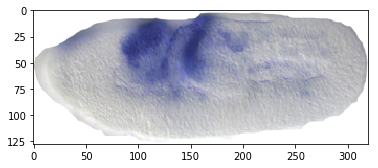

In [67]:
plt.imshow(batch[0][3][0])

In [6]:
tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

[<tf.Tensor 'tower0/custom_cnn/conv1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/custom_cnn/conv2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/custom_cnn/conv3/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_read/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_fg/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/rnn/process/fc_ig/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'tower0/logits/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]